# Credit Card Default

## Problem Statement

A key question for many financial institutions is whether an individual or entity will default on a loan. This important question can have wide implications, not just for a single institution, but also for economies as a whole.

This project will look at predicting the probability of default using machine learning methods. 

In [23]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest

## Data Cleaning

In [24]:
# Import the raw data set and recode names


name_dict = {'ID':'id',
             'Default':'default',
             'Prct_uso_tc':'pct_cc_usage',
             'Edad':'age',
             'Nro_prestao_retrasados':'num_loans_delayed',
             'Prct_deuda_vs_ingresos':'debt_to_income_ratio',
             'Mto_ingreso_mensual':'mthly_inc_amount',
             'Nro_prod_financieros_deuda':'num_loans_and_cc',
             'Nro_retraso_60dias':'num_late_payments',
             'Nro_creditos_hipotecarios':'num_mtg_loans',
             'Nro_retraso_ultm3anios':'pymt_delays',
             'Nro_dependiente':'num_dependents'}

dtype_dict = {'id':'object',
              'default':'bool',
              'pct_cc_usage':'float64',
              'age':'int64',
              'num_loans_delayed':'int64',
              'debt_to_income_ratio':'float64',
              'mthly_inc_amount':'float64',
              'num_loans_and_cc':'int64',
              'num_late_payments':'int64',
              'num_mtg_loans':'int64',
              'pymt_delays':'int64'}

raw_data = (pd.read_csv('data/credit_scoring.csv')
              .rename(columns=name_dict)
              .astype(dtype_dict))

raw_data.dtypes

id                       object
default                    bool
pct_cc_usage            float64
age                       int64
num_loans_delayed         int64
debt_to_income_ratio    float64
mthly_inc_amount        float64
num_loans_and_cc          int64
num_late_payments         int64
num_mtg_loans             int64
pymt_delays               int64
num_dependents          float64
dtype: object

In [25]:
# Calculate the % null by column
display(raw_data.shape)
(raw_data.isnull().sum()/raw_data.shape[0])*100

(150000, 12)

id                       0.000000
default                  0.000000
pct_cc_usage             0.000000
age                      0.000000
num_loans_delayed        0.000000
debt_to_income_ratio     0.000000
mthly_inc_amount        19.820667
num_loans_and_cc         0.000000
num_late_payments        0.000000
num_mtg_loans            0.000000
pymt_delays              0.000000
num_dependents           2.616000
dtype: float64

In [26]:
# Impute the missing data using KNN
# Note: This can take several minutes
imputer = KNNImputer(n_neighbors=5, weights='uniform')
imp_data = imputer.fit_transform(raw_data)


In [27]:
# Reconstruct the data frame and check for missing values
imp_data = pd.DataFrame(imp_data, columns=raw_data.columns)
display(imp_data.head())

# Check the imputed data for missing values
(imp_data.isnull().sum()/imp_data.shape[0])*100

,id,default,pct_cc_usage,age,num_loans_delayed,debt_to_income_ratio,mthly_inc_amount,num_loans_and_cc,num_late_payments,num_mtg_loans,pymt_delays,num_dependents
0,1.0,1.0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,2.0,0.0,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,3.0,0.0,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,4.0,0.0,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


id                      0.0
default                 0.0
pct_cc_usage            0.0
age                     0.0
num_loans_delayed       0.0
debt_to_income_ratio    0.0
mthly_inc_amount        0.0
num_loans_and_cc        0.0
num_late_payments       0.0
num_mtg_loans           0.0
pymt_delays             0.0
num_dependents          0.0
dtype: float64

In [28]:
# Verify data types
imp_data.dtypes

id                      float64
default                 float64
pct_cc_usage            float64
age                     float64
num_loans_delayed       float64
debt_to_income_ratio    float64
mthly_inc_amount        float64
num_loans_and_cc        float64
num_late_payments       float64
num_mtg_loans           float64
pymt_delays             float64
num_dependents          float64
dtype: object

## Data Exploration

Text(0, 0.5, 'Count')

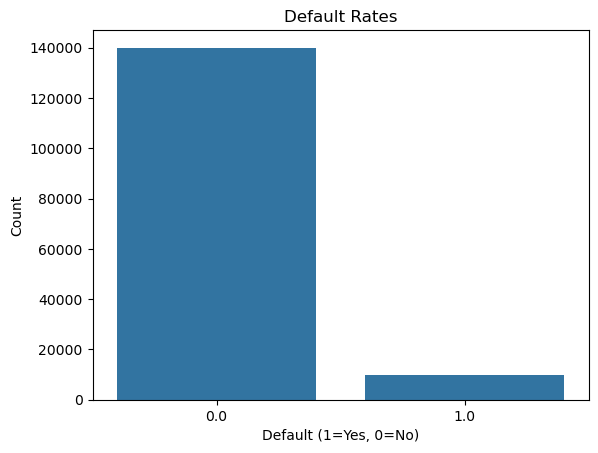

In [29]:
# Plot target feature counts
ax = sns.countplot(imp_data, x='default')
ax.set_title('Default Rates')
ax.set_xlabel('Default (1=Yes, 0=No)')
ax.set_ylabel('Count')


In [30]:
# Calculate the default rate
default_rate = imp_data['default'].mean()
print(f'Default Rate: {default_rate:.1%}')

Default Rate: 6.7%


In [ ]:
# Examine a pairplot
# This can take about 30 minutes to run
sns.pairplot(imp_data, hue='default')

In [ ]:
# Examine Outliers
clf = IsolationForest(random_state=0).fit(imp_data)
imp_data['outlier_score'] = clf.predict(imp_data)
imp_data['outlier_score'].value_counts()

In [ ]:
# Remove outliers and pairplot
imp_no_data = imp_data.query('outlier_score == 1')
sns.pairplot(imp_no_data, hue='default')